This notebook presents an application semi-physical model of the L1 laser in its second version, based on PyTorch.
In particular, in this notebook the optimization process of the control parameters is solved using such a model. 

Author: Francesco Capuano, 2022 S17 summer intern @ ELI-beamlines, Prague


# Motivation

The goal of this project is to maximise second-harmonic efficiency. However, since this metric is also very much related to the shortest possible pulse shape, we started with developing a strategy to optimise a predefinite set of control parameters so as to minimise the difference between the obtained pulse shape (in the temporal domain) and a target one (which, by default, is the shortest one typically). 

However, since data are really expensive to empirically collect we resorted to model the underlying dynamics of the whole system, also considering that (even if not exhaustive) there is a significant amount of know-how concerned with the considered dynamics available.

After this model is obtained, it is possible to use it to obtain the desired control parameters.

In [1]:
%matplotlib widget
import torch
# these import are necessary to import modules from directories one level back in the folder structure
import sys
sys.path.append("../..")
from utils.se import get_project_root
from algorithms.L1_BayesianOptimisation import extract_data
import matplotlib.pyplot as plt
from scipy.optimize import Bounds
import numpy as np
from tqdm import tqdm
from torch.linalg import norm

frequency, field = extract_data()

The preprocessing steps do not depend on the control parameters, therefore they can take place even in numpy

In [2]:
# preprocessing steps
from utils.physics import *
# preprocessing
cutoff = np.array((289.95, 291.91)) * 1e12
# cutting off the signal
frequency_clean, field_clean = cutoff_signal(frequency_cutoff = cutoff, frequency = frequency * 1e12,
                                             signal = field)
# augmenting the signal
frequency_clean_aug, field_clean_aug = equidistant_points(frequency = frequency_clean,
                                                          signal = field_clean,
                                                          num_points = int(3e3)) # n_points defaults to 5e3
# retrieving central carrier
central_carrier = central_frequency(frequency = frequency_clean_aug, signal = field_clean_aug)

However, to be used in the Computational Laser model, their tensor version is required

In [3]:
from utils.LaserModel_torch import ComputationalLaser as CL

intensity = torch.from_numpy(field ** 2)
frequency, field = torch.from_numpy(frequency_clean_aug), torch.from_numpy(field_clean_aug)
compressor_params = -1 * torch.tensor([267.422 * 1e-24, -2.384 * 1e-36, 9.54893 * 1e-50], dtype = torch.double)

laser = CL(frequency = frequency * 1e-12, field = field, compressor_params = compressor_params)
target_time, target_profile = laser.transform_limited()

In [4]:
def L1Loss(GDD, TOD): 
    """
    This function computes the L1-Loss corresponding to a given value of GDD and TOD.
    """
    control = torch.stack([GDD,TOD,torch.tensor(9.54893 * 1e-50)]).requires_grad_(True)
    _, controlled_profile = laser.forward_pass(control)
    return (torch.abs(controlled_profile - target_profile)).sum()

In [5]:
from scipy.optimize import Bounds
bounds_control = Bounds(
                    # GDD         # TOD          # FOD
            lb = (2.3522e-22, -1.003635e-34, 4.774465e-50),
            ub = (2.99624e-22, 9.55955e-35, 1.4323395e-49)
        )

first_two_lower, first_two_upper = bounds_control.lb[:2], bounds_control.ub[:2]
bounds = torch.from_numpy(np.vstack((first_two_lower, first_two_upper)).T)

nsteps = 1000
GDD_linspace = torch.linspace(start = bounds[0,0], end = bounds[0,1], steps = nsteps)
TOD_linspace = torch.linspace(start = bounds[1,0], end = bounds[1,1], steps = nsteps)
GDD_mesh, TOD_mesh = torch.meshgrid(GDD_linspace, TOD_linspace, indexing = "ij")
# reading already simulated data
TL_grid = torch.from_numpy(np.loadtxt("1000x1000_GDDTOD_grid.txt"))

The objective function could also be plotted when considered as a function of **GDD** and **TOD** only.

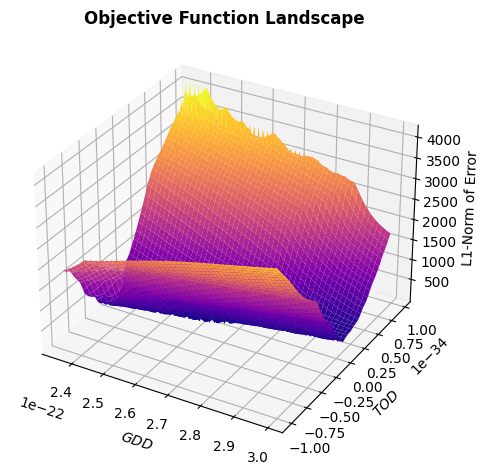

In [6]:
my_map = "plasma"
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.set_xlabel(r"$GDD$"); ax.set_ylabel(r"$TOD$"); ax.set_zlabel("L1-Norm of Error")

surf = ax.plot_surface(GDD_mesh.numpy(), TOD_mesh.numpy(), TL_grid.numpy(), cmap = my_map)

ax.set_title("Objective Function Landscape", fontweight = "bold")

fig.tight_layout()
plt.show()

/var/folders/_q/f5yqvnj16qn6cpl52jqqlxbr0000gn/T/ipykernel_32968/950760796.py:3: UserWarning: The following kwargs were not used by contour: 'offset'
  cset = ax.contourf(


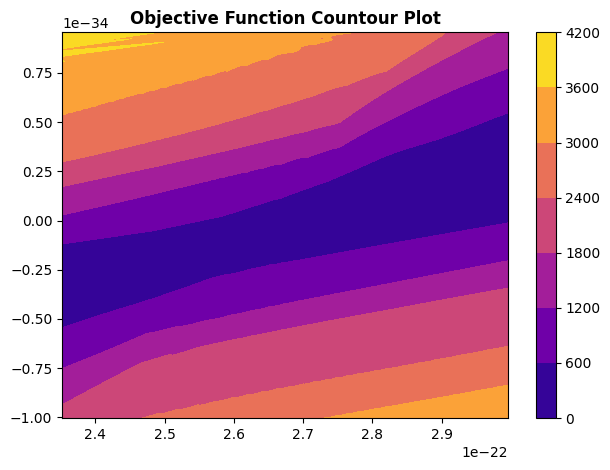

In [7]:
fig, ax = plt.subplots()

cset = ax.contourf(
    GDD_mesh.numpy(), 
    TOD_mesh.numpy(), 
    TL_grid.numpy(), 
    offset = TL_grid.numpy().min(),
    cmap = my_map
)
ax.set_title("Objective Function Countour Plot", fontweight = "bold")
fig.colorbar(cset)
fig.tight_layout()

plt.show()

In [8]:
bounds = torch.from_numpy(
    np.vstack(
        (bounds_control.lb * np.array([1e+24, 1e+36, 1e+48]),
         bounds_control.ub * np.array([1e+24, 1e+36, 1e+48])
        )
    ).T
)

In [9]:
def L1Loss(control): 
    """
    This function computes the L1-Loss corresponding to the given control parameter (in ps^2, ps^3 and ps^4).
    """
    control = control * torch.tensor((1e-24, 1e-36, 1e-48))
    _, controlled_profile = laser.forward_pass(control.requires_grad_(True))
    return (torch.abs(controlled_profile - target_profile)).sum()

class PenalizedFunction: 
    def __init__(self, f, bounds:torch.tensor, penalty_term:torch.tensor):
        """Init function takes only penalty term (to be updated during optimisation) and bounds.
        """
        self.f = f
        self.bounds = bounds
        self.epsilon = penalty_term
    
    def evaluate(self, x:torch.tensor) -> torch.tensor: 
        """
        This function returns the penalized version of the objective function considering input bounds. 
        """
        # minus(lb)-plud(ub) the input array
        pm_input = torch.hstack(list(map(lambda component: torch.stack((-component, component)), x)))
        # reshaping so as to have lower bound/upper bound/lower bound/...
        bounds = self.bounds.reshape(-1)
        # multiplying so as to have +lower bound/-upper bound/+lower bound/ ...
        multipliers = torch.empty_like(bounds)
        multipliers[::2] = 1; multipliers[1::2] = -1
        bounds = bounds * multipliers
        # summing component-wise input and corresponding bound to obtain square violation
        violations = torch.max(torch.zeros_like(bounds), pm_input + bounds) ** 2
        return self.f(x) + (1/self.epsilon) * violations.sum()
    
    def evaluate_root(self, x:torch.tensor) -> torch.tensor: 
        """
        This function returns the penalized version of the objective function considering input bounds. 
        """
        # minus(lb)-plud(ub) the input array
        pm_input = torch.hstack(list(map(lambda component: torch.stack((-component, component)), x)))
        # reshaping so as to have lower bound/upper bound/lower bound/...
        bounds = self.bounds.reshape(-1)
        # multiplying so as to have +lower bound/-upper bound/+lower bound/ ...
        multipliers = torch.empty_like(bounds)
        multipliers[::2] = 1; multipliers[1::2] = -1
        bounds = bounds * multipliers
        # summing component-wise input and corresponding bound to obtain violation
        violations = torch.max(torch.zeros_like(bounds), pm_input + bounds)
        return self.f(x) + (1/self.epsilon) * violations.sum()
      
    def optimize(self, 
                 x0:torch.tensor, 
                 maxit:int=int(1e3), 
                 tolgrad:float=1e-6, 
                 eta_0:float=1,
                 eps:float=1e-3,
                 square:bool=True) -> Tuple[torch.tensor, torch.tensor]: 
        """
        This function optimises the unconstrained (penalized) objective function
        """
        # the objective function is the penalized one 
        f = self.evaluate if square else self.evaluate_root
        k = 0
        xk = x0.requires_grad_(True)
        # giving gradient to xk
        f(xk).backward()

        points = torch.zeros(size = (maxit, len(xk)))
        grads = torch.zeros(maxit)

        grad_k = xk.grad
        
        sum_grad_squared = grad_k ** 2
        lr = eta_0 / torch.sqrt(eps + sum_grad_squared)

        for k in (pbar := tqdm(range(maxit))): 
            # store & display information
            points[k, :] = xk.detach()
            grads[k] = norm(grad_k)
            pbar.set_description("It. {} - Norm Grad {:4e}".format(k+1, norm(grad_k)))
            # update position
            xk = (xk.double() - lr.double() * grad_k.double()).detach().requires_grad_(True)
            # compute gradient at new position
            f(xk).backward()
            grad_k = xk.grad
            # adapt learning rate
            sum_grad_squared += grad_k ** 2
            lr = eta_0 / torch.sqrt(eps + sum_grad_squared)
            # reiterate (if not converged)
            if norm(grad_k) <= tolgrad: 
                points = points[:, :k]
                grads = grads[:k]
                break
            else: 
                k += 1
                # increasing the penalty as iterate progress
                self.epsilon *= .9999
                continue
        return points.detach(), grads

In [10]:
# random start
x0 = torch.tensor([2.5836e+02, 3.1656e+01, 5.6750e-02], dtype=torch.float64, requires_grad=True)
laser_opt = PenalizedFunction(L1Loss, bounds = bounds, penalty_term = torch.tensor(10.))
points, grads = laser_opt.optimize(x0 = x0, eta_0 = 5, maxit = int(1e3))

It. 1000 - Norm Grad 7.235718e-01: 100%|███| 1000/1000 [00:08<00:00, 121.77it/s]


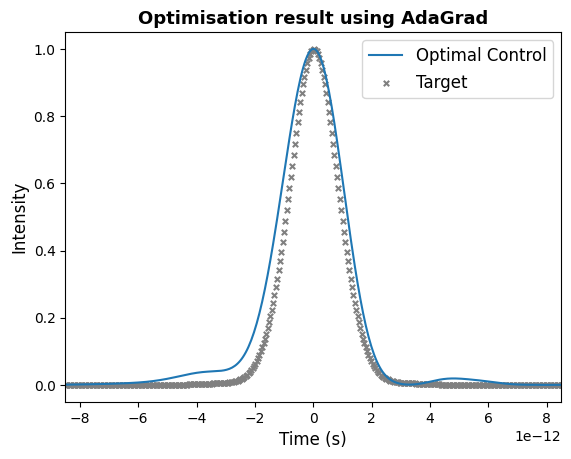

In [11]:
control = points[-1] * torch.tensor([1e-24, 1e-36, 1e-48]) # in SI units
time, profile = laser.forward_pass(control)

fig, ax = plt.subplots()

ax.plot(time,
        torch.roll(profile, -torch.argmax(profile).item() + torch.argmax(target_profile).item()),
        label = "Optimal Control")

ax.scatter(target_time, target_profile, label = "Target", marker = "x", c = "grey", s = 15)

ax.set_xlim(-8.5e-12, 8.5e-12)

ax.legend(fontsize = 12)
ax.set_title("Optimisation result using AdaGrad", fontweight = "bold", fontsize = 13)
ax.set_xlabel("Time (s)", fontsize = 12); ax.set_ylabel("Intensity", fontsize = 12)
plt.show()